# Setup

In [ ]:
# Import Libraries
import pyrfume
from rdkit import Chem
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
# Import SMILES and SMARTS
smarts = pd.read_csv("data/omp8x_smarts42.csv") # 59 x 43
smiles = pd.read_csv("data/omp8x_smiles.txt") # 58 x 1 shape
# Import MODRED Features
mordred = pd.read_csv("data/mordred_features.csv") # 59 x 932 shape

# TRAIN AUTOENCODER
Train an autoencoder on this dataset: https://pubchem.ncbi.nlm.nih.gov/#query=oeYHQGjNDXE6Ww9CjTpGa8jb5ruDGWD6Gt97tgHOabcB11U&alias=PubChem%20Compound%20TOC:%20Fragrances

The idea is to train the autoencoder for dimensionality reduction of the Mordred Features. Since our dataset is only 59 odorants we can utilize the PubMed dataset of Fragrance odorants which are odorants generally similar to the ones used in the analyses. We clean the data by removing 0, NaNs, and troubleshoot mordred calculation problems, as well as remove the 7 odorants that appear in both datasets.

In [ ]:
from mordred_ae.model import FirstMordredLinearAutoEncoder
from mordred_ae.data import Preprocess4Mordred
from mordred_ae.trainer import MordredTrainer
# Here we utilize our custom written package for this express purpose mordred_ae

In [ ]:
from rdkit import Chem
# Structure generation
data = pd.read_csv("PubChem_compound_cache_oeYHQGjNDXE6Ww9CjTpGa8jb5ruDGWD6Gt97tgHOabcB11U.csv")
print(data.shape[0])
data["smiles"].head()
mols = data
mols['rdmol'] = mols['smiles'].map(lambda x: Chem.MolFromSmiles(x))
mols.drop_duplicates(subset="inchi")
# we have mols inchi
print(mols.shape)

# Filter out the chemicals in common
mols = mols[~mols['smiles'].isin(odorants["SMILES"])]
print(mols.shape)

# def embed(mol):
#     mol = Chem.AddHs(mol)
#     Chem.AllChem.EmbedMolecule(mol)
#     Chem.AllChem.MMFFOptimizeMolecule(mol) # Get 3d data based on kinetics.
#     return mol

# # problematic because I have to clean the mol after I add the AddHs (or at least after embed)
# Might have to do a try:, except: and discard the molecules that fail.

# Calculate Mordred Descriptors from rdmol data.
from mordred import Calculator, descriptors
calc = Calculator(descriptors)

df = calc.pandas(mols['rdmol'])
print(df.head)
### df is our mordred data frame
# Let's clean it then.
df = df.map(lambda x: x if isinstance(x, (float, int)) else np.nan)
df = df.dropna(axis=1)
print(df.shape)
 # this was a sharp drop in numbers but anyway, if i can improve the performance of rdmol_optimized and MMFFOptimizer I may get better data.
non_zro_std = df.std() != 0
df = df[non_zro_std[non_zro_std].index]
print(df.shape)
# further drop

common_descriptors = list(set(df.columns) & set(mordred.columns))
trainMordred = df[common_descriptors]
trainMordred.shape

In [146]:
def main():
    preprocessor = Preprocess4Mordred(test_size= 0.2, batch_size=64, validation_split= 0.1)
    train, val, test = preprocessor.prepare_data(trainMordred)
    
    model = FirstMordredLinearAutoEncoder(trainMordred.shape[1], hidden= [256,128,16], dropout= 0.2)
    training  = MordredTrainer(model, learning_rate= 0.001,  weight_decay=0.00001)

    train_losses = []
    val_losses = []
    test_losses = []

    epochs = 500

    for epoch in range(epochs):
        train_loss = training.train(train)
        val_loss = training.evaluation(val)
        test_loss = training.evaluation(test)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Test Loss: {test_loss:.3f}')
    
        # Plot the Training Performane and Loss Distribution
    plt.figure(figsize=(10, 6))
    # Train plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(val_losses, label='Validation Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Training Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.hist(train_losses, alpha=0.5, label='Training', color='red')
    plt.hist(val_losses, alpha=0.5, label='Validation', color='blue')
    plt.hist(test_losses, alpha=0.5, label='Test', color='green')
    plt.title('Loss Distribution')
    plt.xlabel('Loss Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

    torch.save(model.state_dict(), 'final_mordred_model.pth')

Epoch [1/500]
Train Loss: 0.736, Val Loss: 0.412, Test Loss: 0.390
Epoch [11/500]
Train Loss: 0.325, Val Loss: 0.214, Test Loss: 0.231
Epoch [21/500]
Train Loss: 0.226, Val Loss: 0.159, Test Loss: 0.179
Epoch [31/500]
Train Loss: 0.184, Val Loss: 0.165, Test Loss: 0.165
Epoch [41/500]
Train Loss: 0.155, Val Loss: 0.127, Test Loss: 0.151
Epoch [51/500]
Train Loss: 0.137, Val Loss: 0.117, Test Loss: 0.148
Epoch [61/500]
Train Loss: 0.135, Val Loss: 0.118, Test Loss: 0.136
Epoch [71/500]
Train Loss: 0.126, Val Loss: 0.106, Test Loss: 0.135
Epoch [81/500]
Train Loss: 0.131, Val Loss: 0.107, Test Loss: 0.145
Epoch [91/500]
Train Loss: 0.124, Val Loss: 0.097, Test Loss: 0.130
Epoch [101/500]
Train Loss: 0.124, Val Loss: 0.101, Test Loss: 0.137
Epoch [111/500]
Train Loss: 0.103, Val Loss: 0.088, Test Loss: 0.125
Epoch [121/500]
Train Loss: 0.112, Val Loss: 0.092, Test Loss: 0.123
Epoch [131/500]
Train Loss: 0.099, Val Loss: 0.080, Test Loss: 0.115
Epoch [141/500]
Train Loss: 0.100, Val Loss: 

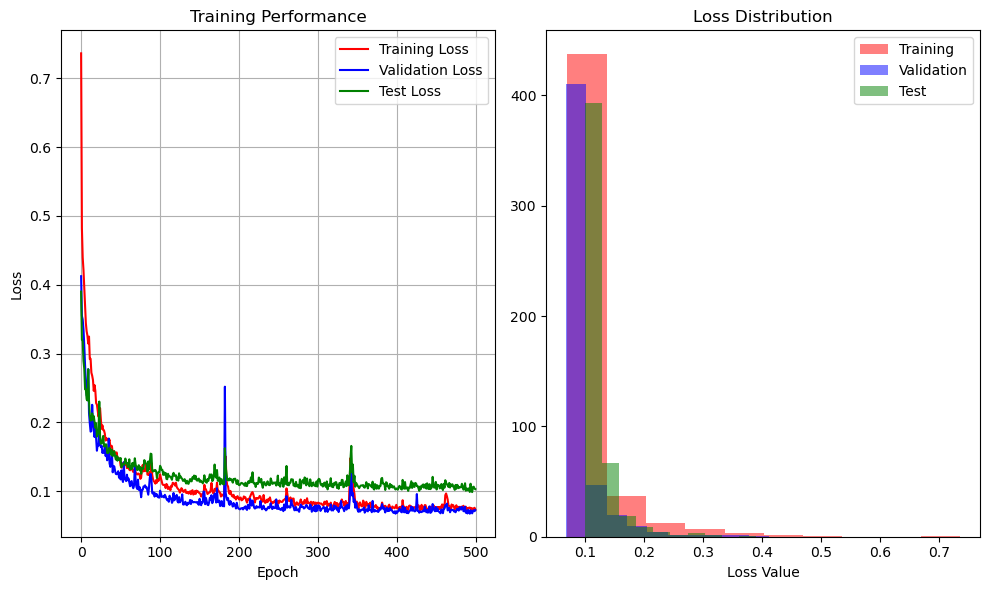

In [147]:
main()

## Extracting the Latent Space

In [ ]:
from mordred_ae.model import FirstMordredLinearAutoEncoder
from mordred_ae.data import Preprocess4Mordred
from mordred_ae.trainer import MordredTrainer

def latentSpace(model, data_loader):
    model.eval()
    latent_vector = []
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to('cpu')
            encoded = model.encoder(x)
            latent_vector.append(encoded.cpu().numpy())
    
    return np.vstack(latent_vector)

latent_mordred = mordred[common_descriptors]

# Initialize our model
model = FirstMordredLinearAutoEncoder(input = latent_mordred.shape[1], hidden= [256,128,16])
model.load_state_dict(torch.load("final_mordred_model.pth"))

# Prepare the data
preprocessor = Preprocess4Mordred(batch_size = 64)
train, val, test = preprocessor.prepare_data(latent_mordred)

# Latent representations
latent_train = latentSpace(model, train)
latent_val = latentSpace(model,val)
latent_test = latentSpace(model, test)

latent_space = np.vstack([latent_train, latent_val, latent_test])

latent_space.shape

(59, 16)

Now that we have extracted the latent space. We will reduce and extract features from the Glomeruli so we can set up the analysis.
We must improve the mordred discriptors number and possibly implement the SMILES and SMARTS ConvNet